In [1]:
import os
import shutil

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

Using TensorFlow backend.


In [2]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 568E-6C47

 Directory of C:\Users\ASUS

29-05-2021  13:01    <DIR>          .
29-05-2021  13:01    <DIR>          ..
20-03-2019  20:30    <DIR>          .anaconda
10-12-2020  21:04    <DIR>          .cache
28-11-2019  01:04    <DIR>          .conda
27-11-2019  23:17                60 .condarc
17-11-2020  17:56    <DIR>          .config
26-11-2020  20:39               435 .dbshell
26-05-2021  18:32    <DIR>          .docker
13-06-2019  13:50    <DIR>          .flickr
24-06-2020  17:47                58 .gitconfig
29-05-2021  12:59    <DIR>          .ipynb_checkpoints
20-03-2019  20:32    <DIR>          .ipython
30-01-2021  18:26    <DIR>          .jupyter
14-07-2019  20:11    <DIR>          .keras
24-08-2019  20:16    <DIR>          .matplotlib
26-11-2020  11:27                 0 .mongorc.js
26-11-2020  22:15                24 .python_history
26-11-2020  20:46                 0 .scala_history
08-03-2021  16:25    <DIR>          .spyder-p

In [3]:
import os
os.chdir(r'D:\DS projects\coins cls\classification_dataset\all')

# Prepare data

In [9]:
# Load images and get labels from filename
images = np.array( np.array( [cv2.imread(r'D:\DS projects\coins cls\classification_dataset\all' + i, cv2.IMREAD_COLOR) for i in os.listdir(r'D:\DS projects\coins cls\classification_dataset\all') if i[-4:] == '.jpg'] ) )
labels = np.array([ i.split('_')[0] for i in os.listdir(r'D:\DS projects\coins cls\classification_dataset\all') if i[-4:] == '.jpg']).astype('int')

## Extract coin frame from image

In [10]:
def extract_coins(img, to_size=100):
    """
    Find coins on the image and return array
    with all coins in (to_size, to_size) frame 
    
    return (n, to_size, to_size, 3) array
           array of radiuses fo coins
    n - number of coins
    color map: BGR
    """
    # Convert to b&w
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find circles on the image
    circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=30, maxRadius=50)
    
    # Convert to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define color range for masking
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
    # Apply the mask
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    
    frames = []
    radiuses = []
    # If circles were not found
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        
        center_x = int(circle[0])
        center_y = int(circle[1])
        
        # If center of coin lays in masked coin range
        if not mask[center_y, center_x]:
            continue
        
        # increase radius by C
        # circle detector tends to decrease radius
        radius = circle[2] + 3
        
        radiuses.append(radius)
        
        # Coordinates of upper left corner of square
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        # As radius was increased the coordinates
        # could go out of bounds
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        # Scale coins to the same size
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation = cv2.INTER_CUBIC)

        frames.append(resized)

    return np.array(frames), radiuses

## Extract coins from image and save to file

In [11]:
scaled = []
scaled_labels = []
radiuses = []
for nominal, image in zip(labels, images):
    prepared, radius = extract_coins(image)
    if prepared is not None and len(prepared):
        scaled.append(prepared[0])
        scaled_labels.append(nominal)
        radiuses.append(radius[0])

# Create dataframe with data and pickle it
data = pd.DataFrame({'label': scaled_labels, 'radius': radiuses, 'image': scaled})
data.to_pickle('file.pickle')

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## Create file structure
```
data/  
    train/  
        5/  
            0.jpg  
            1.jpg  
            ...  
        10/  
            0.jpg  
            1.jpg  
            ...  
        ...  
    validation/  
        5/  
            0.jpg  
            1.jpg  
            ...  
        10/  
            0.jpg  
            1.jpg  
            ...  
        ...  
```

In [12]:
def create_dataset(data, label, train_path, test_path, p=0.2):
    """
    Get data of precise label and split it
    into test and train sets. Save data in
    different folders.
    
    data - data to split
    label - label of the data
    train_path - path to save train subset
    test_path - path to save test subset
    p - ratio of test data to train
    """

    if os.path.exists('{}/{}'.format(train_path, label)):
        shutil.rmtree('{}/{}'.format(train_path, label))
    if os.path.exists('{}/{}'.format(test_path, label)):
        shutil.rmtree('{}/{}'.format(test_path, label))
    
    # Create folder train and test folders
    os.makedirs('{}/{}'.format(train_path, label))
    os.makedirs('{}/{}'.format(test_path, label))
    
    mask = np.random.rand(len(data)) < p
    
    for i, data_record in enumerate(data[mask].image.values):
        cv2.imwrite('{}/{}/{}.jpg'.format(test_path, label, i), data_record)
    
    for i, data_record in enumerate(data[~mask].image.values):
        cv2.imwrite('{}/{}/{}.jpg'.format(train_path, label, i), data_record)

---
# Try models

In [13]:
# Load data
data = pd.read_pickle('file.pickle')

FileNotFoundError: [Errno 2] No such file or directory: 'file.pickle'

## Classify by coin radius

In [14]:
data.dtypes

NameError: name 'data' is not defined

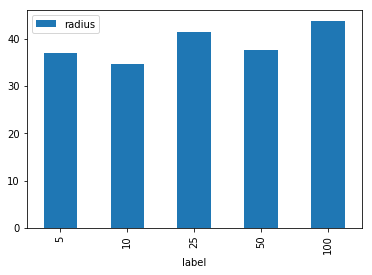

In [9]:
# Radiuses distribution
data.groupby('label').mean().plot.bar()

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data.radius.values, data.label.values, test_size=0.20, random_state=42)
X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)

In [11]:
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
clf.score(X_test, y_test)

0.59733777038269553

# Time for deep learning

In [13]:
# Create train and validation data
for label in data.label.unique():
    create_dataset(data[data['label'] == label], str(label), 'data/train', 'data/validation')

Nominal: 50
Radius: 38.11


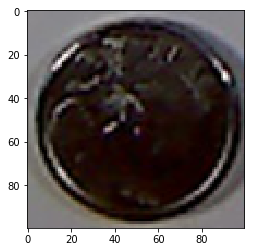

Nominal: 100
Radius: 44.04


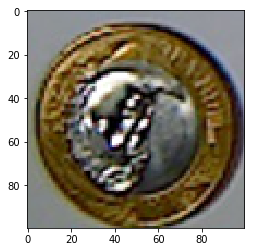

Nominal: 50
Radius: 35.57


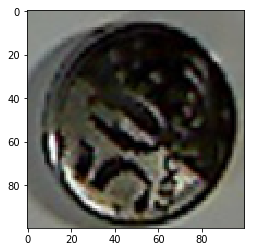

Nominal: 25
Radius: 39.12


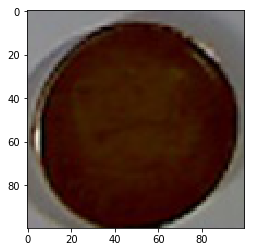

Nominal: 25
Radius: 40.05


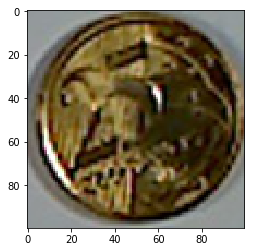

In [14]:
for image in data.iloc[np.random.randint(0, high=len(data), size=5)].values:
    plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))
    print('Nominal: {}'.format(image[1]))
    print('Radius: {:.2f}'.format(image[2]))
    plt.show()

## Image augmenting

In [9]:
# Sligtly augmenting images to increase number
# of images to train
datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.05,
        rescale=1/255,
        zoom_range=0.1,
        fill_mode='nearest')

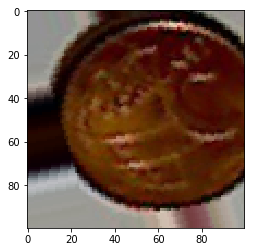

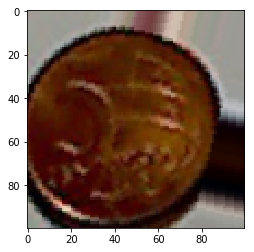

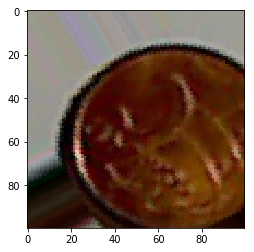

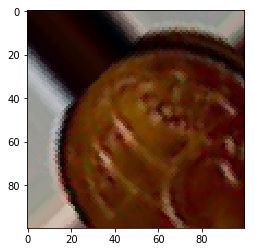

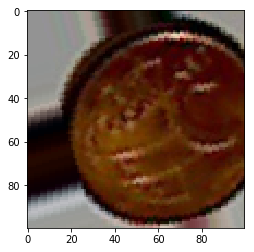

In [12]:
# Show example of augmeting
img = load_img('data/train/5/31.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.imshow(batch[0])
    plt.show()
    
    i += 1
    if i == 5:
        break

## Model 1 (CNN with edge detector)

In [15]:
data = pd.read_pickle('file.pickle')

# Create train and validation data with b&w edge detector
to_edges = lambda image: cv2.adaptiveThreshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=3, C=1)
data.image = data.image.apply(to_edges)

for label in data.label.unique():
    create_dataset(data[data['label'] == label], str(label), 'data/train', 'data/validation')

In [ ]:
for image in data.iloc[np.random.randint(0, high=len(data), size=5)].values:
    plt.imshow(image[0], cmap='gray')
    print('Nominal: {}'.format(image[1]))
    plt.show()

### Model structure

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu')) 
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

### Data generation

In [20]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.05,
        rescale=1/255,
        zoom_range=0.1,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(100, 100),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(100, 100),
        color_mode = 'grayscale',
        batch_size=batch_size,
        class_mode='categorical')

Found 2408 images belonging to 5 classes.
Found 597 images belonging to 5 classes.


### Train model

In [21]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=200 // batch_size)
model.save_weights('threshold_model.h5')

Epoch 1/50
12/12 [==============================] - 7s - loss: 1.6183 - acc: 0.2760 - val_loss: 1.6271 - val_acc: 0.2031
Epoch 2/50
12/12 [==============================] - 5s - loss: 1.6216 - acc: 0.2292 - val_loss: 1.6110 - val_acc: 0.1927
Epoch 3/50
12/12 [==============================] - 5s - loss: 1.6156 - acc: 0.1823 - val_loss: 1.6077 - val_acc: 0.2155
Epoch 4/50
12/12 [==============================] - 5s - loss: 1.6109 - acc: 0.1979 - val_loss: 1.6178 - val_acc: 0.1562
Epoch 5/50
12/12 [==============================] - 9s - loss: 1.6172 - acc: 0.2083 - val_loss: 1.6098 - val_acc: 0.1823
Epoch 6/50
12/12 [==============================] - 7s - loss: 1.6116 - acc: 0.1823 - val_loss: 1.6079 - val_acc: 0.1436
Epoch 7/50
12/12 [==============================] - 6s - loss: 1.6112 - acc: 0.1927 - val_loss: 1.6087 - val_acc: 0.2240
Epoch 8/50
12/12 [==============================] - 5s - loss: 1.6132 - acc: 0.2031 - val_loss: 1.6100 - val_acc: 0.2135
Epoch 9/50
12/12 [==============

## Accuracy is about 30%, very bad results

# CNN with full color image

In [16]:
data = pd.read_pickle('file.pickle')

# Create train and validation data
for label in data.label.unique():
    create_dataset(data[data['label'] == label], str(label), 'data/train', 'data/validation')

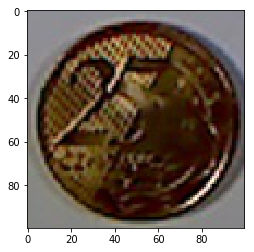

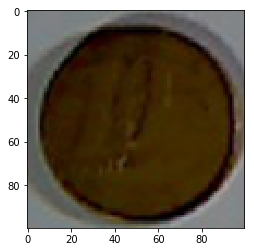

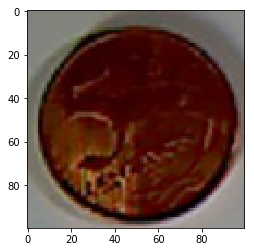

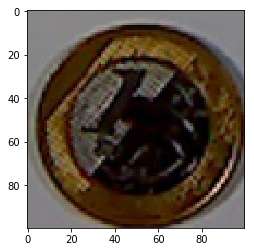

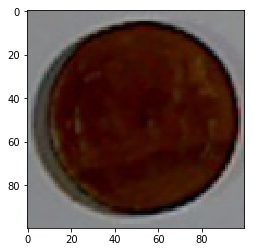

In [23]:
for image in data.iloc[np.random.randint(0, high=len(data), size=5)].values:
    plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))
    plt.show()

### Model structure

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu')) 
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

### Data generation

In [25]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        rescale=1./255,
        zoom_range=0.1,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical')

Found 2428 images belonging to 5 classes.
Found 577 images belonging to 5 classes.


### Train model

In [26]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=200 // batch_size)
model.save_weights('full_color_image.h5')

Epoch 1/50
12/12 [==============================] - 6s - loss: 1.5993 - acc: 0.2083 - val_loss: 1.6281 - val_acc: 0.1458
Epoch 2/50
12/12 [==============================] - 6s - loss: 1.5375 - acc: 0.2760 - val_loss: 1.4470 - val_acc: 0.5052
Epoch 3/50
12/12 [==============================] - 6s - loss: 1.4217 - acc: 0.3802 - val_loss: 1.2311 - val_acc: 0.3842
Epoch 4/50
12/12 [==============================] - 5s - loss: 1.4270 - acc: 0.3333 - val_loss: 1.1628 - val_acc: 0.5365
Epoch 5/50
12/12 [==============================] - 5s - loss: 1.2771 - acc: 0.4844 - val_loss: 1.2645 - val_acc: 0.4167
Epoch 6/50
12/12 [==============================] - 5s - loss: 1.2490 - acc: 0.4688 - val_loss: 0.9681 - val_acc: 0.6271
Epoch 7/50
12/12 [==============================] - 5s - loss: 1.0688 - acc: 0.5938 - val_loss: 0.7849 - val_acc: 0.7135
Epoch 8/50
12/12 [==============================] - 5s - loss: 1.0067 - acc: 0.5677 - val_loss: 0.8703 - val_acc: 0.5677
Epoch 9/50
12/12 [==============

## Accuracy ≈ 80 - 85%, not bad

# Bottleneck fetures from VGG16

### Get feature form VGG16 of train subset

In [27]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1./255)

generator_train = datagen.flow_from_directory(
        'data/train',
        target_size=(100, 100),
        batch_size=1,
        class_mode=None,
        shuffle=False)

bottleneck_features_train = model.predict_generator(generator_train, len(generator_train.filenames))
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

Found 2428 images belonging to 5 classes.


### Get feature form VGG16 of validation subset

In [28]:
generator_validation = datagen.flow_from_directory(
        'data/validation',
        target_size=(100, 100),
        batch_size=1,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = model.predict_generator(generator_validation, len(generator_validation.filenames))
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

Found 577 images belonging to 5 classes.


In [29]:
# Create labels for train subset
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = to_categorical(generator_train.classes)
# Create labels for validation subset
validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = to_categorical(generator_validation.classes)

# Top model
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

### Train model

In [30]:
model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_model.h5')

Train on 2428 samples, validate on 577 samples
Epoch 1/50
2428/2428 [==============================] - 9s - loss: 1.0161 - acc: 0.5980 - val_loss: 0.5566 - val_acc: 0.8388
Epoch 2/50
2428/2428 [==============================] - 8s - loss: 0.5821 - acc: 0.7838 - val_loss: 0.4417 - val_acc: 0.8475
Epoch 3/50
2428/2428 [==============================] - 8s - loss: 0.4387 - acc: 0.8443 - val_loss: 0.3295 - val_acc: 0.8925
Epoch 4/50
2428/2428 [==============================] - 8s - loss: 0.3479 - acc: 0.8793 - val_loss: 0.3193 - val_acc: 0.8925
Epoch 5/50
2428/2428 [==============================] - 8s - loss: 0.2985 - acc: 0.9024 - val_loss: 0.3193 - val_acc: 0.8804
Epoch 6/50
2428/2428 [==============================] - 8s - loss: 0.2633 - acc: 0.9114 - val_loss: 0.2328 - val_acc: 0.9289
Epoch 7/50
2428/2428 [==============================] - 8s - loss: 0.2272 - acc: 0.9250 - val_loss: 0.3141 - val_acc: 0.8648
Epoch 8/50
2428/2428 [==============================] - 8s - loss: 0.2124 - ac

## Accuracy ≈ 95%, not bad at all

# Fine-tuning the top layers of a a VGG16

In [31]:
input_tensor = Input(shape=(100,100,3))
model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(5, activation='softmax'))

# Add the model on top of the conv layers
model = Model(input=model.input, output=top_model(model.output))

for layer in model.layers[:-1]:
    layer.trainable = False

# Use small learning rate to not to boost
# weights change
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


## additional training

In [32]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        rescale=1./255,
        zoom_range=0.15,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical')

Found 2428 images belonging to 5 classes.
Found 577 images belonging to 5 classes.


In [33]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=200 // batch_size)
model.save_weights('VGG_top.h5')

Epoch 1/200
12/12 [==============================] - 73s - loss: 0.5204 - acc: 0.8885 - val_loss: 0.0814 - val_acc: 0.9667
Epoch 2/200
12/12 [==============================] - 63s - loss: 0.4433 - acc: 0.8979 - val_loss: 0.0871 - val_acc: 0.9729
Epoch 3/200
12/12 [==============================] - 63s - loss: 0.3984 - acc: 0.9052 - val_loss: 0.0705 - val_acc: 0.9771
Epoch 4/200
12/12 [==============================] - 61s - loss: 0.3530 - acc: 0.9042 - val_loss: 0.0832 - val_acc: 0.9706
Epoch 5/200
12/12 [==============================] - 63s - loss: 0.4836 - acc: 0.8844 - val_loss: 0.0821 - val_acc: 0.9729
Epoch 6/200
12/12 [==============================] - 60s - loss: 0.4421 - acc: 0.8906 - val_loss: 0.0496 - val_acc: 0.9808
Epoch 7/200
12/12 [==============================] - 63s - loss: 0.3213 - acc: 0.9146 - val_loss: 0.0530 - val_acc: 0.9802
Epoch 8/200
12/12 [==============================] - 63s - loss: 0.3284 - acc: 0.9062 - val_loss: 0.0516 - val_acc: 0.9813
Epoch 9/200
12/1

12/12 [==============================] - 60s - loss: 0.1812 - acc: 0.9260 - val_loss: 0.0903 - val_acc: 0.9729
Epoch 133/200
12/12 [==============================] - 64s - loss: 0.2687 - acc: 0.8948 - val_loss: 0.0697 - val_acc: 0.9792
Epoch 134/200
12/12 [==============================] - 63s - loss: 0.1813 - acc: 0.9250 - val_loss: 0.0788 - val_acc: 0.9792
Epoch 135/200
12/12 [==============================] - 61s - loss: 0.1734 - acc: 0.9333 - val_loss: 0.0865 - val_acc: 0.9785
Epoch 136/200
12/12 [==============================] - 63s - loss: 0.2050 - acc: 0.9156 - val_loss: 0.0839 - val_acc: 0.9740
Epoch 137/200
12/12 [==============================] - 61s - loss: 0.2212 - acc: 0.8969 - val_loss: 0.0732 - val_acc: 0.9808
Epoch 138/200
12/12 [==============================] - 63s - loss: 0.2190 - acc: 0.9104 - val_loss: 0.0758 - val_acc: 0.9750
Epoch 139/200
12/12 [==============================] - 64s - loss: 0.1957 - acc: 0.9167 - val_loss: 0.0880 - val_acc: 0.9698
Epoch 140/200


## Accuracy ≈ 97 - 98%, hm, I think we stop on that spot

# Create pipeline

In [34]:
input_tensor = Input(shape=(100,100,3))
model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(5, activation='softmax'))

# top_model.load_weights('bottleneck_model.h5')

# Add the model on top of the conv layers
model = Model(input=model.input, output=top_model(model.output))

model.load_weights('VGG_top.h5')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [35]:
def find_sum(image, model):
    """
    image: array of images of coins
    model: model that make prediction
    return: sum of coins' nominal
    """
    # Map prediction of model to nominal
    mapper = {0: '10', 1: '100', 2: '25', 3: '5', 4: '50'}
    
    # Scale colors from [0, 255] to [0, 1]
    coins = np.array([cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in extract_coins(image)[0]]) / 255
    
    prediction = model.predict(coins, 1)
    prediction = prediction.argmax(axis=1)
    result = sum([int(mapper[int(i)]) for i in prediction])
    return result

In [41]:
def regression_pipeline(path, model):
    """
    Get images form path and predict sum
    of coins' nominals
    """
    labels = []
    prediction = []
    
    for i, image_path in enumerate(os.listdir(path)):
        if image_path.endswith('.jpg'):
            try:
                label = image_path.split('_')[0]
                image = cv2.imread(path + '/' + image_path, cv2.IMREAD_ANYCOLOR)
                predicted = find_sum(image, model)

                labels.append(int(label))
                prediction.append(predicted)
            except:
                continue

        if (i + 1) % 100 == 0:
            print('{} out of {} done'.format(i + 1, len(os.listdir(path))))

    return np.array(labels), np.array(prediction)

# Results

In [42]:
labels, prediction = regression_pipeline('regression', model)

100 out of 5999 done
200 out of 5999 done
300 out of 5999 done
400 out of 5999 done
500 out of 5999 done
600 out of 5999 done
700 out of 5999 done
800 out of 5999 done
900 out of 5999 done
1000 out of 5999 done
1100 out of 5999 done
1200 out of 5999 done
1300 out of 5999 done
1400 out of 5999 done
1500 out of 5999 done
1600 out of 5999 done
1700 out of 5999 done
1800 out of 5999 done
1900 out of 5999 done
2000 out of 5999 done
2100 out of 5999 done
2200 out of 5999 done
2300 out of 5999 done
2400 out of 5999 done
2500 out of 5999 done
2600 out of 5999 done
2700 out of 5999 done
2800 out of 5999 done
2900 out of 5999 done
3000 out of 5999 done
3100 out of 5999 done
3200 out of 5999 done
3300 out of 5999 done
3400 out of 5999 done
3500 out of 5999 done
3600 out of 5999 done
3700 out of 5999 done
3800 out of 5999 done
3900 out of 5999 done
4000 out of 5999 done
4100 out of 5999 done
4200 out of 5999 done
4300 out of 5999 done
4400 out of 5999 done
4500 out of 5999 done
4600 out of 5999 do

In [43]:
error = abs(labels - prediction)

In [44]:
scipy.stats.describe(error)

DescribeResult(nobs=5976, minmax=(0, 270), mean=6.4508032128514055, variance=299.26720270202151, skewness=4.815593879476777, kurtosis=31.363297106238598)

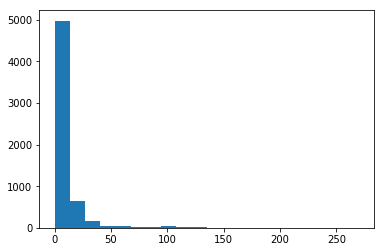

In [45]:
hist = plt.hist(error, bins=20)